In [1]:
import scipy.io
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression as LR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
import math
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV

import missingno as msno
from matplotlib import style
import seaborn as sns



In [2]:
df = pd.read_csv('./ESX01_2706_S.csv', sep='\n', header=0, delimiter=";",decimal=',')
df.columns =['Time','CPU','MEM','REC', 'TRAN','RLATE','WLATE']
df.head()

,Time,CPU,MEM,REC,TRAN,RLATE,WLATE
0,2019-06-27T00:00:00+02:00,1.022600e+10,2.250000e+11,5877248.0,31498752.0,8.0,7.0
1,2019-06-27T00:02:00+02:00,9.362500e+09,2.250000e+11,4866560.0,5431296.0,49.5,72.5
2,2019-06-27T00:04:00+02:00,8.490000e+09,2.250000e+11,5247488.0,5050368.0,47.0,20.0
3,2019-06-27T00:06:00+02:00,9.079000e+09,2.250000e+11,6056960.0,6340608.0,54.5,36.5
4,2019-06-27T00:08:00+02:00,7.504000e+09,2.250000e+11,4986368.0,5183488.0,11.0,14.5


In [5]:
df.shape

(720, 7)

In [4]:
df.dtypes

Time      object
CPU      float64
MEM      float64
REC      float64
TRAN     float64
RLATE    float64
WLATE    float64
dtype: object

In [3]:
DROP_VARIABLES = ['Time']
df = df.drop(DROP_VARIABLES, axis=1)

In [4]:
#CHANGEMENT_TYPE = ['RNFS','R80','R81','R82','R83','R84','R85','WNFS','W80','W81','W82','W83','W84','W85']
#df[CHANGEMENT_TYPE,axis=1]=df[CHANGEMENT_TYPE, axis=1].astype(float64)
#df = df.convert_objects(convert_numeric=True)

In [5]:
#df.dtypes

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CPU,717.0,1.066201e+10,2.116746e+09,0.0,9.204000e+09,1.061850e+10,1.215050e+10,1.764050e+10
MEM,717.0,2.300697e+11,1.123794e+10,0.0,2.250000e+11,2.250000e+11,2.370000e+11,2.430000e+11
REC,715.0,4.021811e+06,4.324623e+06,333824.0,1.747968e+06,3.449856e+06,5.355264e+06,6.660557e+07
TRAN,715.0,7.348249e+06,8.551415e+06,221184.0,2.509824e+06,4.441600e+06,7.407872e+06,4.887552e+07
RLATE,720.0,1.557222e+01,1.487730e+01,0.0,9.000000e+00,1.200000e+01,1.700000e+01,1.885000e+02
WLATE,720.0,1.252361e+01,2.361115e+01,0.0,3.000000e+00,5.500000e+00,1.200000e+01,3.305000e+02


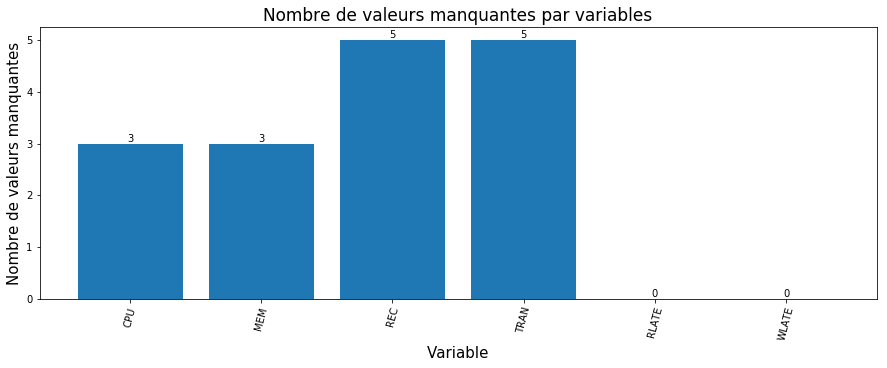

In [7]:
col_names = list(df)
values = []
for col in col_names:
    values.append(sum(df[col] != df[col]))
plt.figure(figsize=(15,5))
plt.xlabel('Variable', fontsize=15)
plt.ylabel('Nombre de valeurs manquantes', fontsize=15)
plt.xticks(range(len(col_names)),col_names, rotation=75)
plt.title('Nombre de valeurs manquantes par variables', size=17)
bar = plt.bar(range(len(col_names)), values, )
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, height,  ha='center', va='bottom')
plt.show()

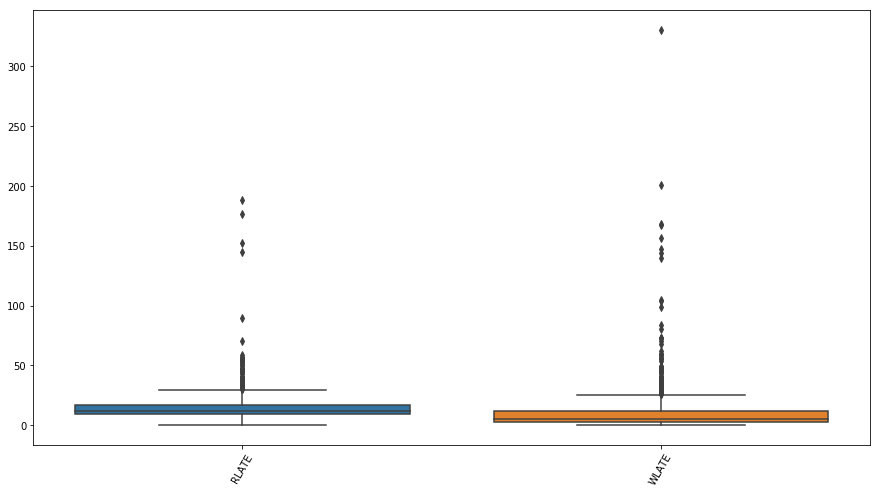

In [8]:

fig, axes = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(15, 8)
sns.boxplot(data=df.drop(['CPU','MEM','REC','TRAN'], axis=1), ax=axes)
axes.set_xticklabels(labels = list(df.drop(['CPU','MEM','REC','TRAN'], axis=1)), rotation=60)
fig=plt.gcf()

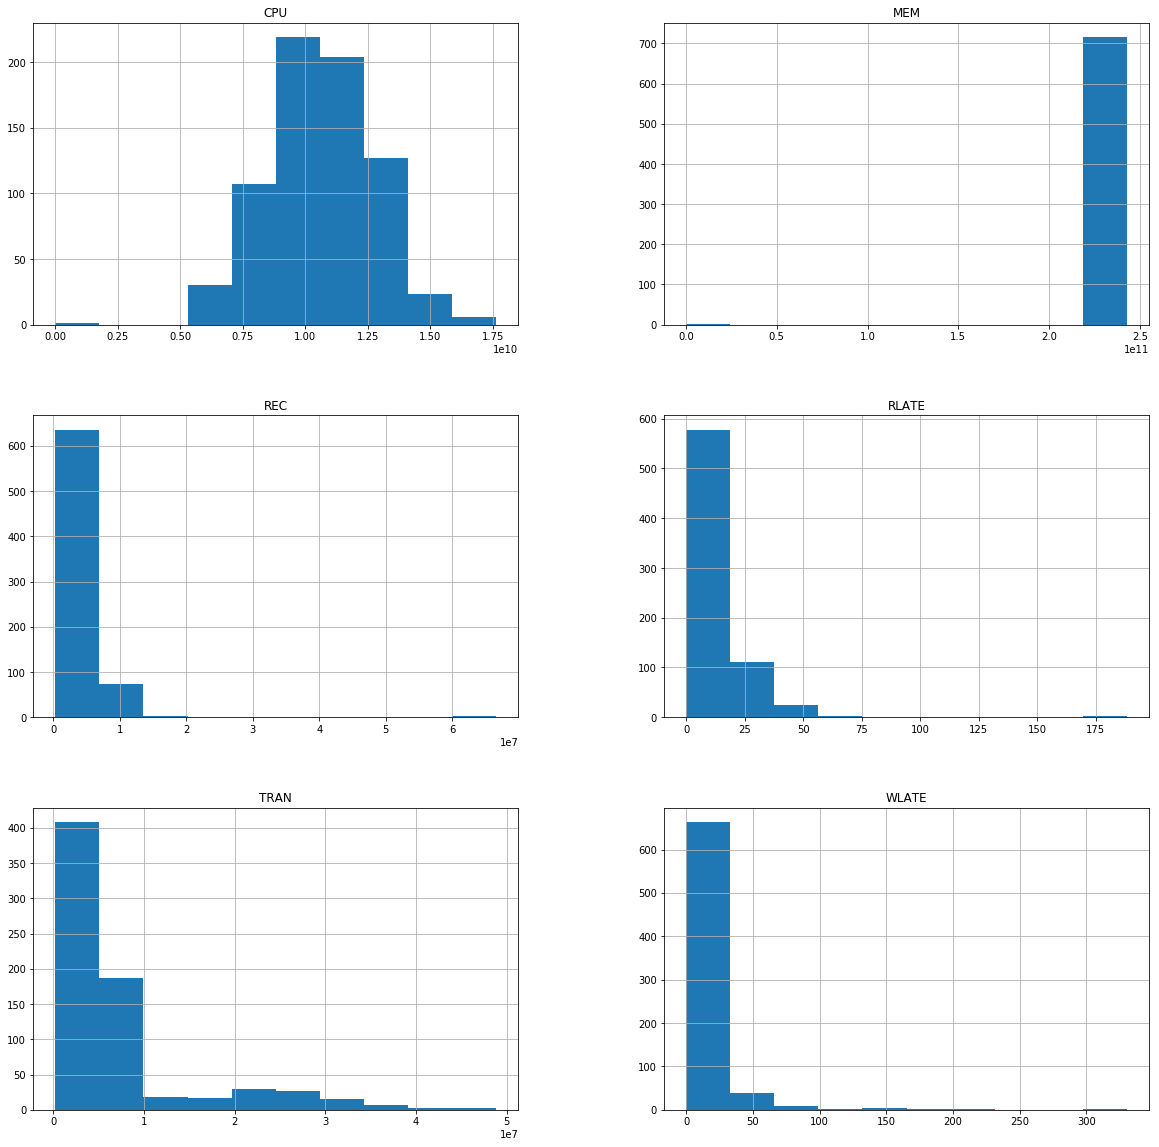

In [9]:
#Plotting the histogram of each column
df.hist(figsize = (20 ,20))
plt.show()

- Nous fesons maintemant une visualization de corrélations entres les variables:

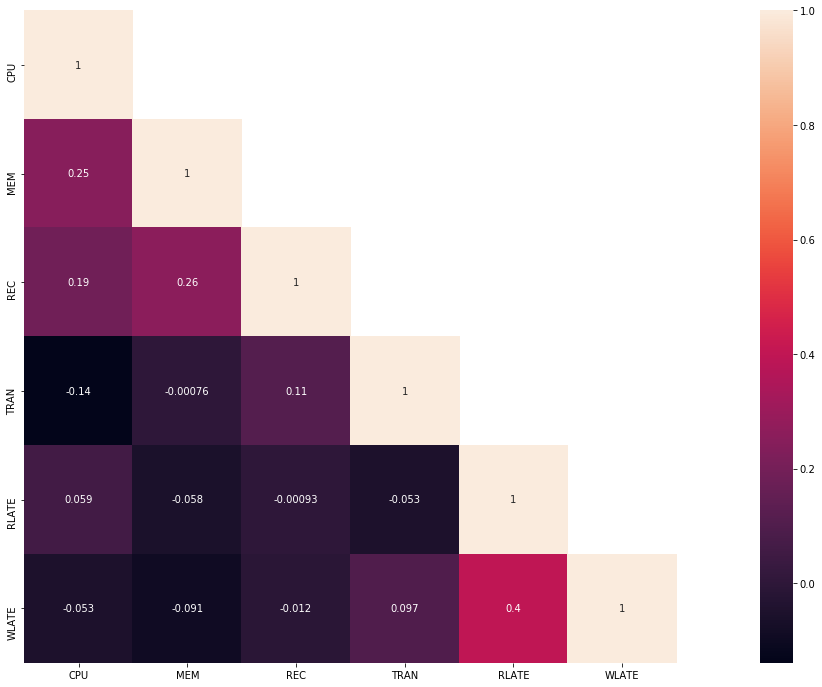

In [10]:

cor_mat= df[list(df)].corr()
mask = np.array(cor_mat)

mask[np.tril_indices_from(mask)] = False
#mask = np.around(mask, decimals=1)
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)
plt.show()

- Nous fesons une autre visualisation pour voir juste les couples de variables qui sont très corrélées:

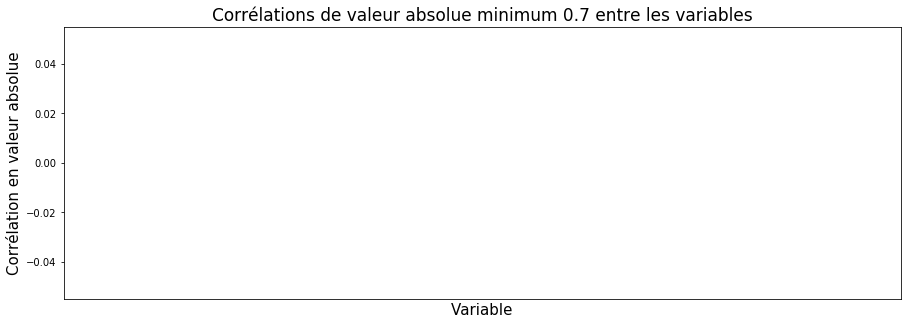

In [11]:
exclus = []
names = []
values = []
LIST_VARIABLES = list(df)
df1 = df.dropna()
for var1 in LIST_VARIABLES:
    for var2 in LIST_VARIABLES:
        if var1!=var2 and (var1, var2) not in exclus:
            corr = np.corrcoef(df1[var1], df1[var2])[1][0]
            if corr<0:
                corr = -corr
            if corr>0.7:
                values.append(corr)
                names.append(str(var1)+'*'+str(var2))
            exclus.append((var1, var2))
            exclus.append((var2,var1))
index = sorted(range(len(values)), key=lambda k: values[k])
values = [values[i] for i in index]
names = [names[i] for i in index]
plt.figure(figsize=(15,5))
plt.xlabel('Variable', size=15)
plt.ylabel('Corrélation en valeur absolue', size=15)
plt.title('Corrélations de valeur absolue minimum 0.7 entre les variables', size=17)
plt.xticks(range(len(index)),names, rotation=75)
bar = plt.bar(range(len(index)), values, tick_label = names)
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, round(height, 4),  ha='center', va='bottom')
    
plt.show()

#### Valeurs manquantes:
- Nous avons deux possibilités pour le traitement des valeurs manquantes dans les colonnes variables: Soit les supprimer, soit les estimer par une valeur numérique. Le premier est plus simple est plus sûr, le deuxème peut nous aider à garder à maximum les observations mais en même temps, qui peut être dangereux, surtout parce que  l'estimation de valeur manquante est difficile à évaluer, et que cette estimation peut être très mal faite, qui rend le résultat final incorrect. Notre solution ici est de tester ces deux solutions afin de les comparer sur un emsemble de test. Nous allons supprimer tous les lignes qui contiennent au moins une valeur manquant:

In [7]:
df = df.dropna()
df.shape

(715, 6)

# Analyse en PCA 

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = StandardScaler().fit_transform(df)
X_scaled = scaler.fit_transform(df)

In [18]:
X

array([[-0.20576596, -0.45220164,  0.42934053,  2.82612991, -0.51440639,
        -0.23670391],
       [-0.61351855, -0.45220164,  0.19547148, -0.22432487,  2.27450713,
         2.53188649],
       [-1.02552102, -0.45220164,  0.28361666, -0.26890166,  2.10650029,
         0.31278731],
       ...,
       [-0.28415267,  1.1488534 ,  0.09393867, -0.39076887, -0.34639955,
        -0.25783819],
       [ 0.2676237 ,  1.1488534 , -0.28186306, -0.54031682,  0.19122233,
         1.81332104],
       [-0.12572651,  1.1488534 , -0.10178153, -0.41509438, -0.44720366,
        -0.02536113]])

In [19]:
X_scaled

array([[0.57968878, 0.92592593, 0.08364687, 0.64285263, 0.03217158,
        0.02118003],
       [0.53073892, 0.92592593, 0.06839621, 0.10708423, 0.25469169,
        0.2193646 ],
       [0.48127888, 0.92592593, 0.07414418, 0.09925496, 0.24128686,
        0.06051437],
       ...,
       [0.57027862, 1.        , 0.06177523, 0.07785074, 0.04557641,
        0.01966717],
       [0.63651824, 1.        , 0.0372691 , 0.0515848 , 0.08847185,
        0.16792738],
       [0.58929736, 1.        , 0.04901226, 0.07357831, 0.03753351,
        0.03630862]])

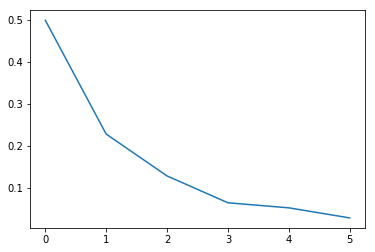

In [9]:
pca = PCA()
## Estimation, calcul des composantes principales
C = pca.fit(X_scaled).transform(X_scaled)
## Décroissance de la variance expliquée
plt.plot(pca.explained_variance_ratio_)
plt.show()

In [21]:
pca.explained_variance_ratio_ 

array([0.49853224, 0.2278645 , 0.12827339, 0.06444879, 0.05242217,
       0.0284589 ])

In [22]:
pca.explained_variance_

array([0.03152263, 0.01440807, 0.00811084, 0.00407515, 0.0033147 ,
       0.00179948])

In [23]:
print(pca.n_components_) 

6


In [24]:
pca.components_

array([[-0.16887051, -0.00747872,  0.03667108,  0.98343655, -0.02853851,
         0.04604519],
       [-0.96324525, -0.11964857, -0.17075623, -0.1621872 , -0.04432096,
         0.02039837],
       [-0.00928218, -0.06563258, -0.02911217, -0.00633563,  0.79278006,
         0.60515975],
       [-0.18997518,  0.24316857,  0.9473871 , -0.0642815 ,  0.0555402 ,
        -0.00439807],
       [ 0.04552573, -0.00910404,  0.04725369, -0.0486578 , -0.60399956,
         0.79273487],
       [ 0.07343044, -0.96026393,  0.2624401 , -0.00283444, -0.02864979,
        -0.05289145]])

In [22]:
#valeur corrigée
n = 6
eigval = (n-1)/n*pca.explained_variance_
print(eigval)

[1.26475851 1.13749758 0.94344161 0.59663251 0.58570261 0.47896998]


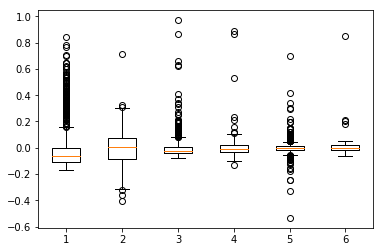

In [25]:
## distribution des composantes principales
plt.boxplot(C[:,0:6])
plt.show()

**Q** Commenter ces résultats: quel choix de la dimension? 

**Q** Présence de valeurs atypiques.

In [26]:
#Définition seuil dépassement pour CPU par exemple 
df["DepSeuil"]=df["CPU"].map(lambda x: x > 1.5e+10)
df.head()

,CPU,MEM,REC,TRAN,RLATE,WLATE,DepSeuil
0,1.022600e+10,2.250000e+11,5877248.0,31498752.0,8.0,7.0,False
1,9.362500e+09,2.250000e+11,4866560.0,5431296.0,49.5,72.5,False
2,8.490000e+09,2.250000e+11,5247488.0,5050368.0,47.0,20.0,False
3,9.079000e+09,2.250000e+11,6056960.0,6340608.0,54.5,36.5,False
4,7.504000e+09,2.250000e+11,4986368.0,5183488.0,11.0,14.5,False


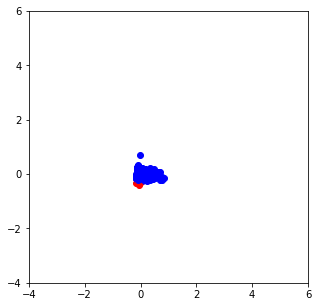

In [27]:
## Repésentation des individus
plt.figure(figsize=(5,5))
for i, j, nom in zip(C[:,0], C[:,1], df['DepSeuil']):
    color = "red" if nom  else "blue"
    plt.plot(i, j, "o",color=color)
plt.axis((-4,6,-4,6))  
plt.show()

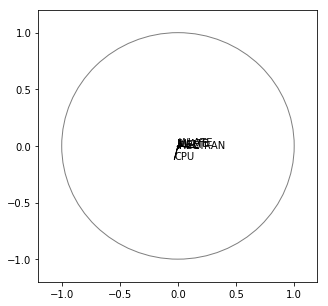

In [28]:
## coordonnées et représentation des variables
coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1,coord2, df.columns):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='black')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
c=plt.Circle((0,0), radius=1, color='gray', fill=False)
ax.add_patch(c)
plt.show()

- Local Outlier Factor

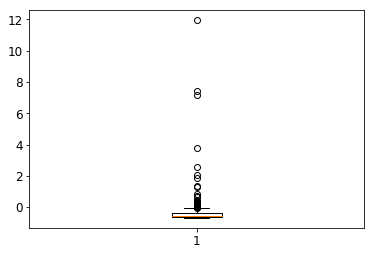

In [58]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.05 ) # choix de n_n par défaut
scoreLOF=clf.fit_predict(X_scaled)
scoreAtyp=-clf._decision_function(X_scaled)# opposé du LOF
plt.boxplot(scoreAtyp)
plt.show()

**Q** Comment se comporte le *LOF* en fonction de *k*?

**Q** Quel taux d'observations par défaut sont considérées comme atypiques?

In [59]:
atypLofInd = clf.fit_predict(X_scaled)

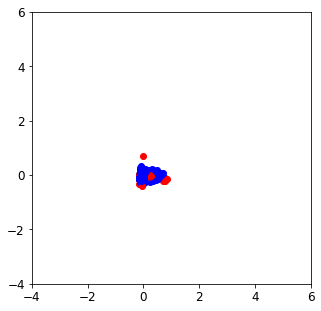

In [60]:
## Repésentation des atypiques
plt.figure(figsize=(5,5))
for i, j, nom in zip(C[:,0], C[:,1], atypLofInd):
    color = "red" if nom!=1  else "blue"
    plt.plot(i, j, "o",color=color)
plt.axis((-4,6,-4,6))  
plt.show()

- OCC SVM

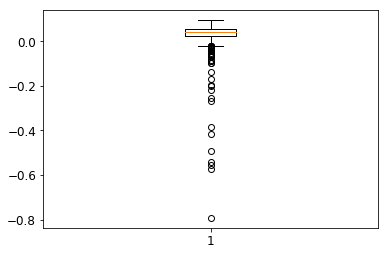

In [66]:
from sklearn.svm import OneClassSVM
clf=OneClassSVM(nu=0.1, gamma=0.01)
scoreSVM=clf.fit(X_scaled)
scoreAtypSVM=clf._decision_function(X_scaled)
plt.boxplot(scoreAtypSVM)
plt.show()

In [67]:
atypSVMInd = clf.predict(X_scaled)

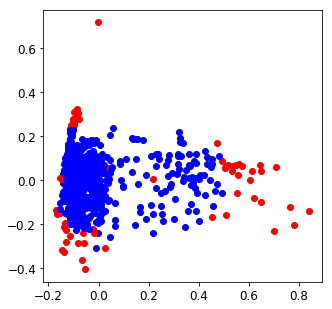

In [69]:
## Repésentation des atypiques
plt.figure(figsize=(5,5))
for i, j, nom in zip(C[:,0], C[:,1], atypSVMInd):
    color = "red" if nom!=1  else "blue"
    plt.plot(i, j, "o",color=color)
#plt.axis((-4,6,-4,6))  
plt.show()

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (1000) is greater than the total number of samples (715). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))


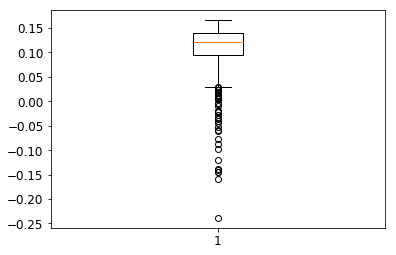

In [70]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(max_samples=1000, contamination=0.05)
scoreIF=clf.fit(X_scaled)
scoreAtypIF=clf.decision_function(X_scaled)
plt.boxplot(scoreAtypIF)
plt.show()

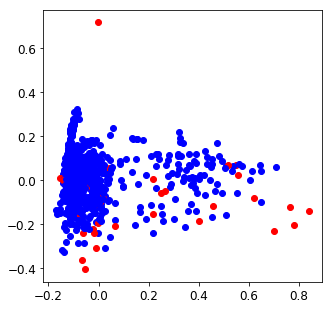

In [71]:
atypIFInd = clf.predict(X_scaled)
## Repésentation des atypiques
plt.figure(figsize=(5,5))
for i, j, nom in zip(C[:,0], C[:,1], atypIFInd):
    color = "red" if nom!=1  else "blue"
    plt.plot(i, j, "o",color=color)
#plt.axis((-4,6,-4,6))  
plt.show()

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0, 'time')

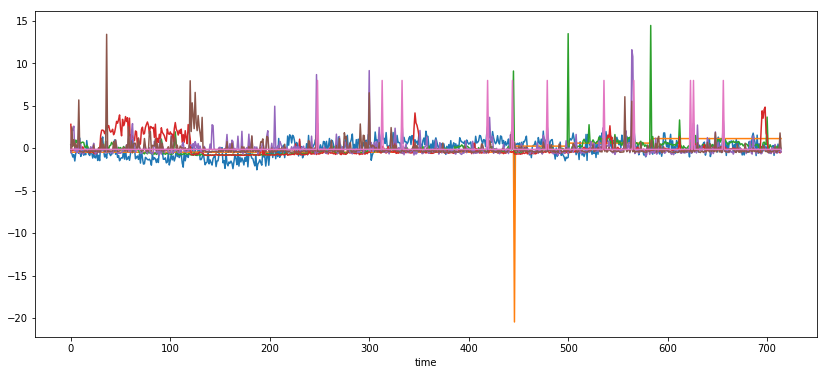

In [37]:
scaler_std = StandardScaler()
scaler_std.fit(df)
df_std = scaler_std.transform(df)
plt.figure(figsize=(14,6))
plt.plot(df_std)
plt.xlabel('time')

In [80]:
df_std

array([[-0.21557532, -0.73434875,  0.42892569, ..., -0.13868314,
        -0.40945734,  1.34568987],
       [-0.63030982, -0.73377063,  0.19562792, ...,  1.66864606,
         0.72857997,  2.06413215],
       [-1.04936697, -0.7338429 ,  0.28355778, ..., -0.10392681,
         0.01730665,  1.34568987],
       ...,
       [-0.29530425,  1.7137647 ,  0.09434312, ..., -0.13868314,
        -0.33833001, -0.27080525],
       [ 0.26592014,  1.71492094, -0.28054064, ...,  0.06985485,
        -0.12494801,  0.6272476 ],
       [-0.13416537,  1.71427055, -0.10089899, ...,  0.06985485,
         0.01730665,  0.08841589]])

In [72]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

In [73]:
isforest = IsolationForest()
isforest.fit(X_scaled)
detection_std = isforest.predict(X_scaled)
print("Anomalous time series are ", [i+1 for i,x in enumerate(detection_std) if x == -1])

Anomalous time series are  [2, 4, 9, 32, 37, 46, 50, 56, 57, 59, 60, 62, 63, 75, 78, 80, 81, 82, 86, 91, 92, 102, 105, 106, 114, 121, 123, 124, 126, 129, 133, 143, 144, 158, 206, 248, 301, 327, 347, 348, 349, 422, 446, 447, 476, 501, 536, 537, 539, 542, 543, 548, 558, 565, 566, 567, 584, 591, 613, 627, 629, 631, 649, 657, 687, 695, 696, 697, 698, 699, 701, 714]


In [20]:
#detection_std

In [75]:
onesvm = OneClassSVM()
onesvm.fit(X_scaled)
detection_a = onesvm.predict(X_scaled)
print("Anomalous time series are ", [i+1 for i,x in enumerate(detection_a) if x == -1])

Anomalous time series are  [1, 2, 3, 4, 5, 9, 25, 26, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 66, 67, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 196, 197, 198, 199, 200, 201, 202, 204, 205, 206, 207, 209, 210, 211, 212, 215, 216, 219, 220, 221, 222, 223, 224, 225, 226, 228, 229, 230, 231, 232, 233, 234, 235, 237, 238, 239, 240, 243, 248, 249, 258, 263, 264, 268, 270, 27

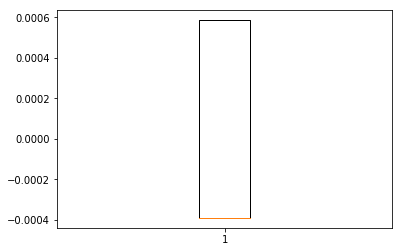

In [22]:
clf=OneClassSVM(nu=0.1, gamma=0.01)
scoreSVM=clf.fit(df)
scoreAtypSVM=clf._decision_function(df)
plt.boxplot(scoreAtypSVM)
plt.show()

In [23]:
atypSVMInd = clf.predict(df)

In [24]:
## Repésentation des atypiques
plt.figure(figsize=(5,5))
for i, j, nom in zip(C[:,0], C[:,1], atypSVMInd):
    color = "red" if nom!=1  else "blue"
    plt.plot(i, j, "o",color=color)
plt.axis((-4,6,-4,6))  
plt.show()

NameError: name 'C' is not defined

<Figure size 360x360 with 0 Axes>

In [10]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Gaussian Mixture 

In [11]:
from sklearn.mixture import GaussianMixture

In [2]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X_scaled)

NameError: name 'X_scaled' is not defined

In [40]:
gm.weights_

array([0.30816354, 0.47945142, 0.21238504])

In [41]:
gm.means_

array([[0.61878428, 0.97529619, 0.08514614, 0.10408438, 0.04798293,
        0.01368175],
       [0.58863069, 0.92589788, 0.03636895, 0.16304165, 0.05651175,
        0.0221984 ],
       [0.61908312, 0.9528619 , 0.05637582, 0.17062452, 0.14753155,
        0.10954058]])

In [42]:
gm.covariances_

array([[[ 1.04409030e-02,  2.62956590e-03,  5.10490863e-04,
          7.94457330e-04,  1.98640411e-04, -1.71418941e-04],
        [ 2.62956590e-03,  4.81664588e-03,  5.55771452e-04,
          9.60306573e-04, -4.67497072e-04, -3.20532814e-04],
        [ 5.10490863e-04,  5.55771452e-04,  1.01951698e-02,
          1.67735159e-03, -2.92092902e-05,  4.12312819e-04],
        [ 7.94457330e-04,  9.60306573e-04,  1.67735159e-03,
          2.93055425e-03, -5.43718945e-05,  6.86174174e-06],
        [ 1.98640411e-04, -4.67497072e-04, -2.92092902e-05,
         -5.43718945e-05,  3.97745783e-04,  6.50563982e-05],
        [-1.71418941e-04, -3.20532814e-04,  4.12312819e-04,
          6.86174174e-06,  6.50563982e-05,  1.20063935e-04]],

       [[ 1.62527186e-02,  3.49031295e-06,  1.26502321e-03,
         -5.03284101e-03, -1.29782638e-04, -1.85301019e-04],
        [ 3.49031295e-06,  1.11463362e-06,  6.38939451e-07,
         -4.41293763e-06,  9.69919552e-07, -3.67421219e-08],
        [ 1.26502321e-03,  6.3

In [43]:
gm.converged_

True

In [44]:
gm.n_iter_

25

In [45]:
gm.predict(X)

array([2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0,
       2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2,
       0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2,
       2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2,
       0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2,
       2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2,
       0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 2,
       2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2,

In [12]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [13]:
from matplotlib.colors import LogNorm
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_scaled)
gm_reduced = gm.fit(X_reduced)
def plot_gaussian_mixture(clusterer, X_reduced, resolution=1000, show_ylabels=True):
    mins = X_reduced.min(axis=0) - 0.1
    maxs = X_reduced.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    plt.plot(X_reduced[:,0], X_reduced[:,1],'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [50]:
X_reduced

array([[ 0.49389308, -0.05751489],
       [-0.02251917,  0.07331509],
       [-0.02858737,  0.11859938],
       ...,
       [-0.06196959,  0.03743237],
       [-0.09428256, -0.01680496],
       [-0.06885519,  0.02268088]])

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


Saving figure gaussian_mixtures_plot


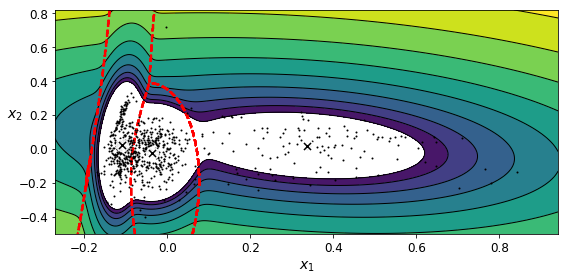

In [55]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm_reduced, X_reduced)

save_fig("gaussian_mixtures_plot")
plt.show()

## Anomaly Detection using Gaussian Mixtures

In [77]:
densities = gm.score_samples(X_reduced)
density_threshold = np.percentile(densities, 4)
anomalies = X_reduced[densities < density_threshold]

In [78]:
density_threshold

-1.0953596019433032

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


Saving figure mixture_anomaly_detection_plot


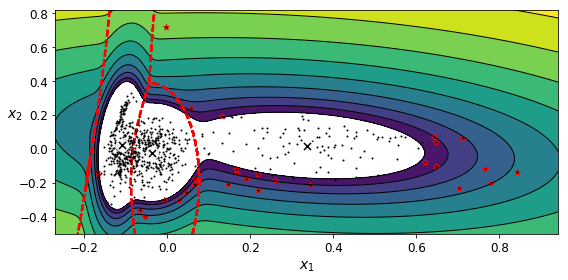

In [80]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm_reduced, X_reduced)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
#plt.ylim(top=5.1)

save_fig("mixture_anomaly_detection_plot")
plt.show()

### Test GMM for 2 class

In [50]:
gm = GaussianMixture(n_components=2, n_init=10, random_state=42)
#gm.fit(X_scaled)plt.figure(figsize=(8, 4))
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_scaled)
gm.fit(X_reduced)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=10, precisions_init=None,
        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


Saving figure gaussian_mixtures_plot


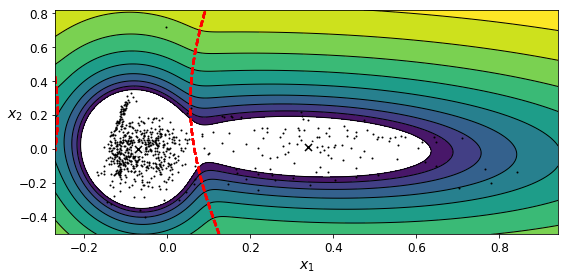

In [52]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm_reduced, X_reduced)

save_fig("gaussian_mixtures_plot")
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


Saving figure mixture_anomaly_detection_plot


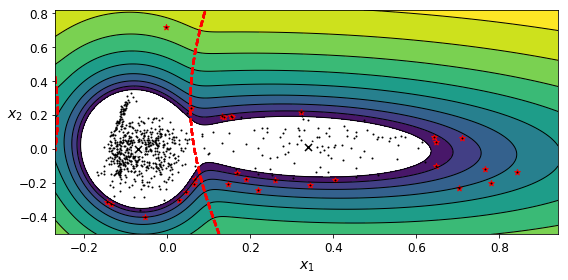

In [53]:
densities = gm.score_samples(X_reduced)
density_threshold = np.percentile(densities, 4)
anomalies = X_reduced[densities < density_threshold]

plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm_reduced, X_reduced)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
#plt.ylim(top=5.1)

save_fig("mixture_anomaly_detection_plot")
plt.show()

# TEST FOR ONE ANOTHER DAY 

In [27]:
test = pd.read_csv('./ESX01_1907.csv', sep='\n', header=0, delimiter=";",decimal=',')
test.columns =['Time','CPU','MEM','REC', 'TRAN','RLATE','WLATE']

In [29]:
test = test.drop(['Time'], axis =1)

In [31]:
test = test.fillna(test.mean())

In [32]:
test_scaled = scaler.fit_transform(test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [37]:
test_reduced = pca.fit_transform(test_scaled)

In [55]:
densities_test = gm.score_samples(test_reduced)

In [56]:
anomalies_test = test_reduced[densities_test < density_threshold]

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


Saving figure mixture_anomaly_detection_plot


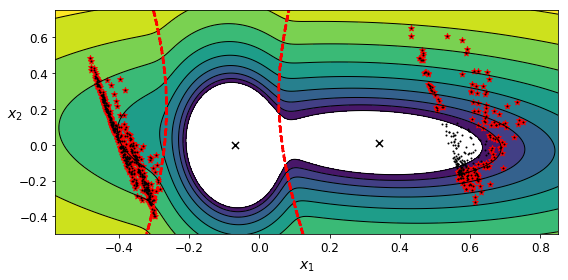

In [58]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, test_reduced)
plt.scatter(anomalies_test[:, 0], anomalies_test[:, 1], color='r', marker='*')
#plt.ylim(top=5.1)

save_fig("mixture_anomaly_detection_plot")
plt.show()

## comparison of 2 datas

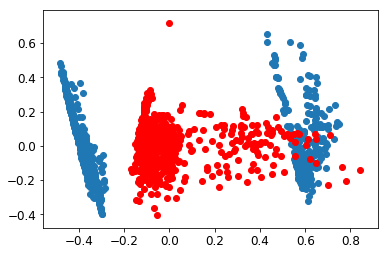

In [61]:
# recall that the 2 data with pca is test_reduced and X_reduced
plt.scatter(test_reduced[:,0], test_reduced[:,1])
plt.scatter(X_reduced[:,0], X_reduced[:,1], color='red')
plt.show()